<a href="https://colab.research.google.com/github/esemsc-as6323/symbolic-regression-with-deep-neural-networks-workshop/blob/main/Symbolic%20regression%20with%20deep%20neural%20networks%20workshop%20-%20student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a target="_blank" href="https://colab.research.google.com/github/benmoseley/symbolic-regression-with-deep-neural-networks-workshop/blob/main/Symbolic%20regression%20with%20deep%20neural%20networks%20workshop%20-%20student.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Symbolic regression with deep neural networks

Written by Ben Moseley, April 2025.

In this workshop we will train **deep neural networks** to carry out **symbolic regression**. This workshop is inspired by these papers: [Deep Learning for Symbolic Mathematics, Lample and Charton, 2019](https://arxiv.org/abs/1912.01412) and [End-to-end symbolic regression with transformers, Kamienny et al, 2022](https://arxiv.org/abs/2204.10532).

The workshop is split into 3 parts:
 - Part 1: Understanding mathematical expressions and how to generate them
 - Part 2: Generating a training dataset of expressions and tokenization
 - Part 3: Training a deep neural network to carry out symbolic regression

# Assessment

You will be assessed on **your completion of each task in this notebook**. Each task is labelled like this:
 > **Task 0.0**: Complete this!

 Please fill in your code in the cell provided below each task.


# Goal

The goal of this workshop is to train a network to identify a mathematical expression given example data points from the expression. More precisely, given a dataset, $\mathscr{D} = \{(x_0, f(x_0)), \dots, (x_N, f(x_N))\}$, consisting of $N$ observed data points from a unknown function $f(x)$, can we predict the underlying **mathematical expression** for $f(x)$?

<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-task.png" width="60%"></div>

Note:
- We are not just doing function fitting! In function fitting, we want to predict the **value** of $f$ given $\mathscr{D}$. In symbolic regression we want to discover the underlying **mathematical expression** of $f$ given $\mathscr{D}$. This means the network must predict an **expression**.
- For simplicity, we only consider **scalar** (1D) functions with a single **input variable** ($x$) and **integer** constant coefficients. It is a fun task to extend the methods in this notebook to higher dimensions with floating point constants!

# Approach

We will use a deep neural network to **directly predict $f(x)$ given $\mathscr{D}$ as input to the network**, as shown below:

<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-train.png" width="80%"></div>

<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-infer.png" width="80%"></div>

In Part 2 we will explain how to enable the network to directly predict symbolic expressions by using **tokenization** and **autoregressive prediction**.

# Part 1: Understanding mathematical expressions and how to generate them

Our first step is to understand how to define and (randomly) generate mathematical expressions in Python. This code will be necessary in Part 2 to generate a training dataset of expressions for training the neural network.

## Part 1a: Defining mathematical expressions in Python

One useful way to represent a mathematical expression is through a **tree** consisting of:
- Nodes, which are either:
    - Binary operations: e.g. $+, -, /$, or
    - Unary operations: e.g. $\sin, \cos, \exp, \text{sqr}, \text{abs}$, and
- Leaves, which are
    - Input variables, e.g. $x, y, z$ (note in this case we just consider $x$, the 1D case).

For example, the expression $f(x) = \sin(x + x^2)$ can be represented as the following tree:

<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-tree.png" width="40%"></div>


We will now randomly generate an expression tree in Python using two steps:

1. Create a random binary tree consisting of only binary operations and leaves,
2. Randomly add unary operations to the nodes of the tree.

> **Task 1.1**: Complete the `generate_random_binary_tree` function so that given a list of binary operators, a list of tree leaves (input variables), and the total number nodes in the tree, it generates a random binary tree of only **binary operations**. Use `print_tree` to print out some generated trees.

> HINT: a good way to work with trees is to use **recursion** (i.e. functions which call themselves) to iteratively build and traverse the tree.

In [34]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import json
import gzip

import torchvision.transforms as transforms

In [2]:
# Define available binary operators and leaf symbols
binary_operators = {
    "+": lambda l, r: l + r,
    "-": lambda l, r: l - r,
    "*": lambda l, r: l * r,
}
leaves = ("x",)


class TreeNode:
    """A node in a binary tree representing a mathematical expression.

    Attributes:
        val (str): The operator value at this node.
        left (TreeNode or str): The left child (subtree or leaf).
        right (TreeNode or str): The right child (subtree or leaf).
    """
    def __init__(self, val=None, left=None, right=None):
        self.val = val      # Node value: operator
        self.left = left    # Left child node or leaf
        self.right = right  # Right child node or leaf


def generate_random_binary_tree(n_operators, binary_operators=binary_operators, leaves=leaves):
    """Generates a random expression tree consisting of binary operators.

    Args:
        n_operators (int): Number of binary operators to include in the tree.
        binary_operators (dict): Mapping from binary symbols to binary functions.
        leaves (tuple of str): Set of allowable leaf values (input variables).

    Returns:
        TreeNode: The root of the randomly generated expression tree.
    """
    # Create a new root node with a random operator
    root = TreeNode()
    root.val = random.choice(list(binary_operators.keys()))
    n_operators -= 1

    # Randomly split the remaining operators between left and right subtrees
    left_n_operators = random.randint(0, n_operators)
    right_n_operators = n_operators - left_n_operators


    ## TODO: assign `root.left` and `root.right` attributes
    if(left_n_operators != 0):
        root.left = generate_random_binary_tree(left_n_operators, binary_operators, leaves)

    if(right_n_operators != 0):
        root.right = generate_random_binary_tree(right_n_operators, binary_operators, leaves)

    # Corresponding to the case when we are on a leaf
    if(root.left == None):
        root.left = random.choice(leaves)

    if(root.right == None):
        root.right = random.choice(leaves)

    return root


def str_tree(root, level=0, prefix="Root "):
    """Returns a pretty string representation of a TreeNode expression tree.

    Args:
        root (TreeNode or str): The current node or leaf.
        level (int): The current depth in the tree (for indentation).
        prefix (str): Prefix label for the node (e.g. 'Root ', 'L-- ').

    Returns:
        str: A formatted string representing the tree.
    """
    indent = " " * (level * 4)
    if isinstance(root, TreeNode):
        s = indent + prefix + str(root.val) + "\n"
        s += str_tree(root.left, level + 1, "L-- ")
        s += str_tree(root.right, level + 1, "R-- ")
        return s
    else:  # Leaf node
        return indent + prefix + str(root) + "\n"


def print_tree(root):
    """Pretty-prints the tree structure."""
    print(str_tree(root))


random.seed(123)
for _ in range(5):
    root = generate_random_binary_tree(n_operators=4, binary_operators=binary_operators, leaves=leaves)
    print_tree(root)
    print()

Root +
    L-- +
        L-- -
            L-- x
            R-- x
        R-- x
    R-- -
        L-- x
        R-- x


Root -
    L-- *
        L-- x
        R-- +
            L-- x
            R-- x
    R-- +
        L-- x
        R-- x


Root +
    L-- x
    R-- +
        L-- +
            L-- x
            R-- +
                L-- x
                R-- x
        R-- x


Root -
    L-- *
        L-- +
            L-- x
            R-- x
        R-- x
    R-- *
        L-- x
        R-- x


Root *
    L-- x
    R-- *
        L-- x
        R-- *
            L-- x
            R-- -
                L-- x
                R-- x




> **Task 1.2**: Complete the `add_random_unary_operators` function so that, given a binary tree (represented by a tree of `TreeNode`s), a list of unary operators, and the total number unary operators to add, the function randomly inserts unary operators into the tree.

> HINT: we can simply treat unary operators as binary operators with a `TreeNode.right = None` attribute set to `None`.

In [3]:
# Define available unary operators
unary_operators = {
    "abs": lambda o: sp.Abs(o),
    "sin": lambda o: sp.sin(o),
    "tan": lambda o: sp.tan(o),
    "exp": lambda o: sp.exp(o),
}


def add_random_unary_operators(root, n_operators, unary_operators=unary_operators):
    """Adds unary operations randomly to internal nodes of a binary expression tree.

    Args:
        root (TreeNode): The root of the binary expression tree.
        n_operators (int): Number of unary operations to insert.
        unary_operators (dict): Mapping from unary symbols to unary functions.

    Returns:
        TreeNode: The root of the updated expression tree.
    """
    if not isinstance(root, TreeNode):
        raise Exception(f"root is not a TreeNode, {root}")

    # Collect all internal (non-leaf) nodes into a flat list
    nodes = []
    def collect_nodes(node):
        if isinstance(node, TreeNode):
            nodes.append(node)
            collect_nodes(node.left)
            collect_nodes(node.right)
    collect_nodes(root)

    # Randomly add unary operations
    for _ in range(n_operators):

        # Randomly choose a node to wrap in a unary operator
        chosen_node = random.choice(nodes)


        ## TODO: wrap the chosen in a new TreeNode, `new_node`.
        ## The new node should have a unary value, a left attribute as the chosen node, and `None` as the right attribute
        new_node = TreeNode()
        new_node.val = random.choice(list(unary_operators.keys()))
        new_node.left = chosen_node
        # Since we are creating a unary expression, we only add a single attribute
        new_node.right = None

        # Update references to the chosen node in the tree
        if root is chosen_node:
            root = new_node
        else:
            for node in nodes:  # Update in-place references
                if node.left is chosen_node:
                    node.left = new_node
                elif node.right is chosen_node:
                    node.right = new_node

        # Add the new unary node to the list for possible further wrapping
        nodes.append(new_node)

    return root


random.seed(123)
for _ in range(3):
    root = generate_random_binary_tree(n_operators=2, binary_operators=binary_operators, leaves=leaves)
    print("Before unary operations added:")
    print_tree(root)
    root = add_random_unary_operators(root, n_operators=3, unary_operators=unary_operators)
    print("After unary operations added:")
    print_tree(root)
    print()

Before unary operations added:
Root +
    L-- +
        L-- x
        R-- x
    R-- x

After unary operations added:
Root +
    L-- tan
        L-- abs
            L-- sin
                L-- +
                    L-- x
                    R-- x
                R-- None
            R-- None
        R-- None
    R-- x


Before unary operations added:
Root -
    L-- *
        L-- x
        R-- x
    R-- x

After unary operations added:
Root exp
    L-- exp
        L-- abs
            L-- -
                L-- *
                    L-- x
                    R-- x
                R-- x
            R-- None
        R-- None
    R-- None


Before unary operations added:
Root +
    L-- x
    R-- +
        L-- x
        R-- x

After unary operations added:
Root tan
    L-- +
        L-- x
        R-- exp
            L-- exp
                L-- +
                    L-- x
                    R-- x
                R-- None
            R-- None
    R-- None




## Part 1b: using SymPy to display expressions

Great! Now we are able to generate random mathematical expressions. Wouldn't it be nice to display the actual mathematical expression, rather than print out the tree? Fortunately, we can use [`sympy`](https://docs.sympy.org/latest/index.html) to help us!

`sympy` is a Python library for symbolic mathematics. It allows us to directly manipulate mathematical expressions in Python, for example:

In [4]:
# Define a symbolic variable
x = sp.Symbol("x")

# Construct a symbolic expression using unary and binary operations
f = sp.Abs(x**2 + sp.sin(x + x))

# Display the symbolic expression
f

Abs(x**2 + sin(2*x))

Note how `sympy` doesn't compute the value of $f$, but rather holds on to the expression itself. Also note how `sympy` automatically simplified the expression for us.

### Evaluating mathematical expressions with `sympy`

We can efficiently evaluate the expression given many values of `x` by using `sp.lambdify`:

(100,) (100,)


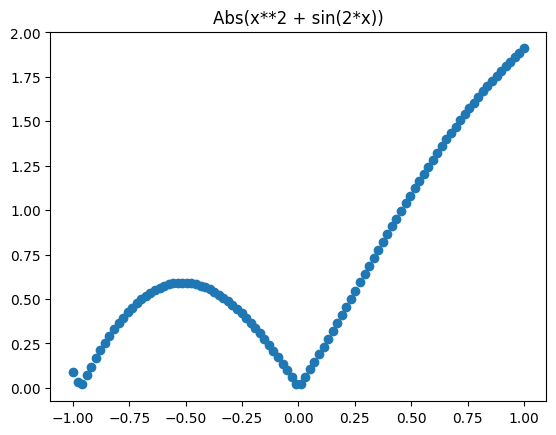

In [5]:
# Convert the symbolic expression `f` to a numerical function using NumPy
fn = sp.lambdify(args=x, expr=f, modules="numpy")

# Generate input values and evaluate the function
x_values = np.linspace(-1, 1, 100)  # 100 points between -1 and 1
f_values = fn(x_values)  # Evaluate the function on the input values

# Print shapes for verification
print(x_values.shape, f_values.shape)

# Plot the evaluated function
plt.figure()
plt.scatter(x_values, f_values)
plt.title(f)
plt.show()

Ok, now we are ready to convert our Python trees to `sympy` expressions.

> **Task 1.3**: complete the `tree_to_sympy` function, which converts a tree of `TreeNode`s to a `sympy` expression.

> HINT: use recursion again to help build the expression up from its leaves!

In [6]:
def tree_to_sympy(root, binary_operators = binary_operators, unary_operators = unary_operators, leaves = leaves):
    """Converts a binary tree expression into a SymPy expression.

    Args:
        root (TreeNode): The root of the binary expression tree.
        binary_operators (dict): Mapping from binary symbols to binary functions.
        unary_operators (dict): Mapping from unary symbols to unary functions.
        leaves (tuple of str): Set of allowable leaf values (input variables).

    Returns:
        sympy.Expr: The SymPy expression corresponding to the tree.
    """
    if isinstance(root, TreeNode):
        if root.val in binary_operators:


            ## TODO: complete building the sympy expression for a binary operator.
            ## Recursively build left and right `sympy` expressions, then evaluate
            ## and return the binary `sympy` expression.
            exp_left = tree_to_sympy(root.left, binary_operators, unary_operators, leaves)
            exp_right = tree_to_sympy(root.right, binary_operators, unary_operators, leaves)

            # Apply the binary operator (lambda function) on left and right
            return binary_operators[root.val](exp_left, exp_right)

        elif root.val in unary_operators:

            ## TODO: complete building the sympy expression for a unary operator.
            ## Recursively build left `sympy` expression, then evaluate and return
            ## the unary `sympy` expression.

            exp_left = tree_to_sympy(root.left, binary_operators, unary_operators, leaves)

            # The right leaf is empty (operation is unary)
            assert root.right is None
            return unary_operators[root.val](exp_left)

        else:
            raise Exception(f"root value not recognised: {root.val}")  # Unrecognized operator
    else:  # leaf node
        assert root in leaves  # Ensure the root is a valid leaf value
        expr = sp.Symbol(root)  # Convert leaf value to a SymPy symbol
        return expr


# Example tree: (x * x) + sin(x + x)
root = TreeNode("+", TreeNode("*", "x", "x"), TreeNode("sin", TreeNode("+", "x", "x"), None))
print_tree(root)

# Convert the tree to a SymPy expression and verify the result
tree_to_sympy(root, binary_operators, unary_operators, leaves)

Root +
    L-- *
        L-- x
        R-- x
    R-- sin
        L-- +
            L-- x
            R-- x
        R-- None



x**2 + sin(2*x)

# Part 2: Generating a training dataset of expressions and tokenization

In this part we will generate a large dataset of expressions using the code above. We will also **filter** and **tokenize** the expressions in the dataset to make them suitable for machine learning. We will use this dataset to train a neural network to carry out symbolic regression in Part 3.

Remember our goal is to train a network so that given the input $\mathscr{D} = \{(x_0, f(x_0)), \dots, (x_N, f(x_N))\}$, it predicts the expression for $f(x)$.

Thus, we need to generate many examples of $\mathscr{D}$ and $f$ as training data. We define the training dataset so that **each example** in the dataset consists of a **randomly generated $f$ (using the code above) and its corresponding observations, $\mathscr{D}$**, which we will compute using `sympy`.

## Part 2a: Generating many random expressions


Our first step is to generate many random expressions using the code above.


> **Task 2.1**: use `generate_random_binary_tree`, `add_random_unary_operators`, and `tree_to_sympy` to generate 100,000 random expressions.

> HINT: if you were unable to complete these functions in Part 1, you can skip this task and just load some pre-computed trees using the code below.

In [7]:
# Maximum number of binary and unary operators for tree generation
max_n_binary_operators = 4
max_n_unary_operators = 3

# Lists to store the generated tree roots and corresponding SymPy expressions
roots = []
exprs = []

random.seed(123)
for i in range(100000):  # Generate 100,000 trees (should take 1-2 mins)

    # Randomly sample the size of the tree
    n_binary_operators = random.randint(1, max_n_binary_operators)
    n_unary_operators = random.randint(1, max_n_unary_operators)


    ## TODO: generate a random tree and append it to `roots`.
    ## Also convert the tree to its `sympy` expression and append it to `exprs`.

    tree = generate_random_binary_tree(max_n_binary_operators)
    add_random_unary_operators(tree, max_n_unary_operators)
    roots.append(tree)
    exprs.append(tree_to_sympy(tree))

# Print the lengths of the generated trees and expressions
print(len(roots), len(exprs))

# Print the first few expressions for verification
print(exprs[:5])

100000 100000
[x + Abs(x - sin(x + Abs(x**2))), x*exp(exp(2*x)) + 2*x, tan(x**2)*tan(x + exp(x**2)), -x + exp(sin(2*x*exp(2*x))), x]


In [ ]:

## OPTIONAL: Use this code to skip Task 2.1 and load pre-computed `roots` and `exprs`

def load_trees(filename="trees.json"):
    """Loads pre-computed trees and their corresponding SymPy expressions from a compressed JSON file."""
    with gzip.open(filename, "rt", encoding="utf-8") as f:
        data = json.load(f)

    # Convert the tree dictionaries back into TreeNode objects and parse expressions
    roots = [dict_to_tree(d) for d in data["trees"]]
    exprs = [sp.sympify(s, evaluate=False) for s in data["exprs"]]  # Parse expressions as SymPy objects
    return roots, exprs


def dict_to_tree(root):
    """Converts a dictionary representation of a tree back into a TreeNode object."""
    if isinstance(root, dict):
        return TreeNode(
            val=root["val"],
            left=dict_to_tree(root["left"]),
            right=dict_to_tree(root["right"]),
        )
    else:
        return root  # Leaf node value

# Load pre-computed `roots` and `exprs`
roots, exprs = load_trees()

# Print the length of the loaded trees and expressions
print(len(roots), len(exprs))

# Print the first few expressions for verification
print(exprs[:5])

Next, we need to evaluate $\mathscr{D} = \{(x_0, f(x_0)), \dots, (x_N, f(x_N))\}$ for each of these functions. For simplicity, we will use the **same** $x_i$ values for all expressions, sampled regularly over the range $[-1,1]$, with $N=100$, i.e. `x_values = np.linspace(-1,1,100)`.

> **Task 2.2**: complete the code below to generate $\mathscr{D}$ for each expression.

> HINT: you can use `sp.lambdify` to evaluate $f$ as shown above.

In [8]:
# Values to evaluate each expression over
x_values = np.linspace(-1, 1, 100)

# List to store the observational data for each expression
datas = []

for expr in exprs:

    ## TODO: Compute observational `data` for each expression and append it to `datas`.
    ## `data` should be a `numpy` array of shape (N, 2), where the first column contains
    ## `x_values`, and the second column contains `f(x_values)`.
    x = sp.Symbol('x')
    func = sp.lambdify(x, expr, 'numpy')
    y_values = func(x_values)

    # In case we evaluate a constant x, we do not get an array. For this case,
    # we create an array and fill it with this constant value
    if(np.isscalar(y_values)):
      y_values = np.full_like(x_values, y_values)

    data = np.column_stack((x_values, y_values))
    datas.append(data)

    # Ensure that the data is a numpy array with shape (100, 2)
    assert isinstance(data, np.ndarray) and datas[-1].shape == (100, 2)

<lambdifygenerated-68>:2: RuntimeWarning: overflow encountered in exp
  return x - exp(exp(2*x + tan(2*x)))
<lambdifygenerated-499>:2: RuntimeWarning: overflow encountered in exp
  return -x*(-x + exp(exp(exp(2*x)))) + x
<lambdifygenerated-609>:2: RuntimeWarning: overflow encountered in exp
  return x + exp(x + exp(exp(3*x)))
<lambdifygenerated-1511>:2: RuntimeWarning: overflow encountered in exp
  return -x**2 + exp(exp(x*tan(2*x)))
<lambdifygenerated-1572>:2: RuntimeWarning: overflow encountered in exp
  return x + exp(exp(x + tan(3*x)))
<lambdifygenerated-2080>:2: RuntimeWarning: overflow encountered in exp
  return x - exp(x*(-x + exp(tan(2*x))))
<lambdifygenerated-2160>:2: RuntimeWarning: overflow encountered in exp
  return 3*x*exp(exp(exp(2*x)))
<lambdifygenerated-2327>:2: RuntimeWarning: overflow encountered in exp
  return x + exp(exp(2*x + exp(2*x)))
<lambdifygenerated-2864>:2: RuntimeWarning: overflow encountered in exp
  return 2*x*exp(exp(tan(x**2 + x)))
<lambdifygenerated

## Part 2b: Filtering the dataset

As the dataset was being generated, you may have noticed two things:
1. some of the expressions are quite extreme (such as $f=\exp(\exp(\exp(x)))$), and `sp.lambdify` emits overflow `RuntimeWarning`s when computing the value of $f$.
2. by random chance, many of the expressions generated have the same tree structure (i.e. are the same expression).

So, next we will filter our training dataset to:
1. remove extreme expressions, and
2. remove duplicate trees.

> **Task 2.3**: Filter out expressions where the absolute value of any $f(x_i)$ in $\mathscr{D}$ is greater than 10. Also filter out all duplicate trees from the dataset.

> HINT: you can check for duplicates by using `str_tree` to serialise each tree.

In [9]:
# Lists to store the filtered roots, expressions, and corresponding data
roots_filtered = []
exprs_filtered = []
datas_filtered = []
roots_unique = []  # To keep track of unique tree structures (to filter duplicates)

# Loop through all the generated trees, expressions, and their observational data
for root, expr, data in zip(roots, exprs, datas):

    serial_tree = str_tree(root)

    ## TODO: Filter out extreme expressions and duplicate trees from `roots`, `exprs`, and `datas`.
    if(serial_tree not in roots_unique and np.max(data)<10):
      roots_filtered.append(root)
      exprs_filtered.append(expr)
      datas_filtered.append(data)
      roots_unique.append(serial_tree)

# Print the number of trees remaining after filtering, and how many were removed
print(f"Total number of trees in filtered dataset: {len(roots_filtered)} ({len(roots)-len(roots_filtered)} trees removed)")

Total number of trees in filtered dataset: 65462 (34538 trees removed)


Finally, now we have generated and filtered the dataset, let's plot a few examples in the dataset look reasonable.

> **Task 2.4:** Plot the observational data for a few example expressions in the dataset.

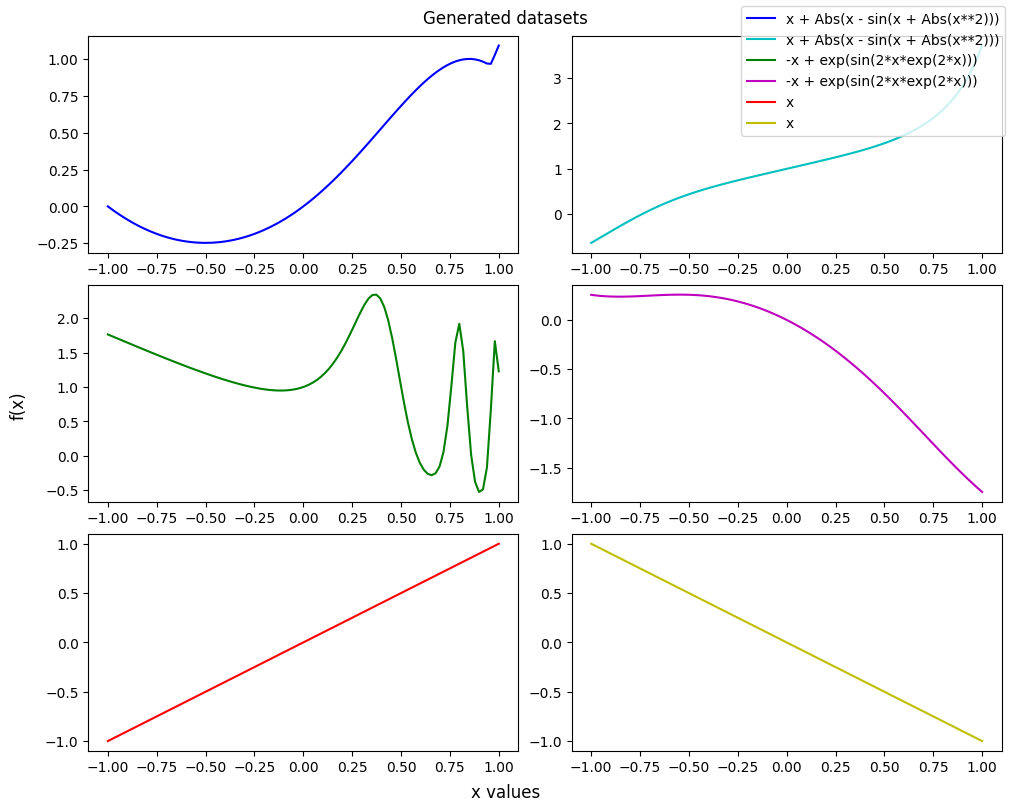

In [10]:
## TODO: Plot a few examples in the filtered dataset.
fig, axs = plt.subplots(3,2, constrained_layout=True, figsize=(10, 8))

colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i in range(3):
  axs[i,0].plot(datas_filtered[i][:,0], datas_filtered[i][:,1], label=exprs_filtered[i], color=colors[i])
  axs[i,1].plot(datas_filtered[i+3][:,0], datas_filtered[i+3][:,1], label=exprs_filtered[i], color=colors[i+3])

plt.suptitle("Generated datasets")
fig.supxlabel("x values")
fig.supylabel("f(x)")
fig.legend()
plt.show()

## Part 2c: Tokenization

Neural networks fundamentally process **numbers** (stored as **vectors**). But we want our network to directly predict a **mathematical expression**. Therefore, we need a way to represent a mathematical expression as a number (or sequence of numbers), so that the network can manipulate and predict it. We also need a way to convert back and forth between expressions and their numerical representation, so that we can read out the predicted expressions.

The process of converting non-vector inputs, such as text or symbols, into numerical vectors suitable for machine learning is known as **tokenization**. What we need is a **unique mapping** that allows us to go from expressions to vectors (tokens) and from vectors (tokens) back to expressions. The simplest way to do this is to define a **dictionary**, where all expression symbols are assigned a unique integer index. In our case, we will use the mapping:

| Symbol    | Token |
|-----------|-------|
| `+`       | 0     |
| `-`       | 1     |
| `*`       | 2     |
| `abs`     | 3     |
| `sin`     | 4     |
| `tan`     | 5     |
| `exp`     | 6     |
| `x`       | 7     |
| `None`    | 8     |
| `<EOS>`   | 9     |
| `<PAD>`   | 10    |

`<EOS>` and `<PAD>` are special "end of sequence" and "padding" symbols we added which will be useful for training our neural network and will be described in Part 3.

Now, given an expression tree, such as

<pre>Root sin
    L-- *
        L-- x
        R-- x
    R-- None</pre>

We can go through and replace each symbol with its token:

<pre>Root 4
    L-- 2
        L-- 7
        R-- 7
    R-- 8</pre>

Finally, we can turn this into a vector by **flattening** the tree. There are many possible ways to flatten trees; in this case we will use **prefix notation**, writing each node before its children, listed from left to right:

``[4, 2, 7, 7, 8]``

The task of predicting $f$ thus turns in to the task of predicting a **sequence of integers**. This can be thought of as a **classification task**, and it allows us to use a **cross-entropy loss function** to train our network (very similiar to how modern LLMs are trained).

The code below:
1. defines our tokenization maps
2. defines `tree_to_prefix_sequence` and `prefix_sequence_to_tree` functions
3. computes a list of vectors, `vecs_filtered`, for the training dataset above.

> **Task 2.5**: run the code below, and make sure you understand what each line is doing.

> **Task 2.6**: plot a histogram showing the count of each token over the entire training dataset.

In [11]:
def create_token_maps(binary_operators, unary_operators, leaves):
    """
    Creates forward and backward token maps.

    Args:
        binary_operators (dict): Mapping from binary symbols to binary functions.
        unary_operators (dict): Mapping from unary symbols to unary functions.
        leaves (tuple of str): Set of allowable leaf values (input variables).

    Returns:
        forward_token_map (dict): Mapping from symbol to token index.
        backward_token_map (dict): Mapping from token index to symbol.
    """
    # Combine all tokens (binary operators, unary operators, leaves, special tokens)
    all_tokens = list(binary_operators.keys()) + list(unary_operators.keys()) + list(leaves) + [None,] + ["<EOS>"] + ["<PAD>"]

    # Create forward and backward token maps
    return ({token: idx for idx, token in enumerate(all_tokens)},
            {idx: token for idx, token in enumerate(all_tokens)})

def tree_to_prefix_sequence(root):
    """
    Converts a binary tree to polish notation.

    Args:
        root (TreeNode): The root node of the tree.

    Returns:
        list: A list representing the polish notation of the tree.
    """
    if isinstance(root, TreeNode):
        return [root.val] + tree_to_prefix_sequence(root.left) + tree_to_prefix_sequence(root.right)
    else:  # Leaf node
        return [root]

def prefix_sequence_to_tree(sequence, binary_operators, unary_operators, leaves):
    """
    Converts a prefix sequence back to a binary tree.

    Args:
        sequence (list): The prefix sequence.
        binary_operators (dict): Mapping from binary symbols to binary functions.
        unary_operators (dict): Mapping from unary symbols to unary functions.
        leaves (tuple of str): Set of allowable leaf values (input variables).

    Returns:
        root (TreeNode): The reconstructed binary tree root.
    """
    def build_binary_tree(iterator):
        val = next(iterator)
        root = TreeNode()
        root.val = val

        # If the value is an operator, recursively build left and right subtrees
        if val in binary_operators or val in unary_operators:
            count_left, root.left = build_binary_tree(iterator)
            count_right, root.right = build_binary_tree(iterator)
            if val in unary_operators:
                assert root.right is None  # Unary operators should not have a right child
        else:
            # If it's a leaf node, return the value
            assert val in leaves + (None,)  # Check consistency
            return 1, val  # Leaf node

        return 1 + count_left + count_right, root

    count, root = build_binary_tree(iter(sequence))
    assert count == len(sequence)  # Ensure the number of nodes matches the sequence length
    return root

# Create forward and backward token maps for the vocabulary
forward_token_map, backward_token_map = create_token_maps(binary_operators, unary_operators, leaves)

# Print token maps and vocabulary size
print(f"forward token map: {forward_token_map}")
print(f"backward token map: {backward_token_map}")
n_tokens = len(forward_token_map)
print(f"Vocabulary size: {n_tokens}")

# Convert the filtered roots to prefix sequences and their corresponding vector representations
seqs_filtered = [tree_to_prefix_sequence(root) for root in roots_filtered]
vecs_filtered = [np.array([forward_token_map[s] for s in seq]) for seq in seqs_filtered]

# Display information for the first two trees in the filtered dataset
for root, seq, vec in zip(roots_filtered[:2], seqs_filtered, vecs_filtered):
    print_tree(root)
    print(f"Flattened tree: {seq}")
    print(f"Vector representation: {vec}")

forward token map: {'+': 0, '-': 1, '*': 2, 'abs': 3, 'sin': 4, 'tan': 5, 'exp': 6, 'x': 7, None: 8, '<EOS>': 9, '<PAD>': 10}
backward token map: {0: '+', 1: '-', 2: '*', 3: 'abs', 4: 'sin', 5: 'tan', 6: 'exp', 7: 'x', 8: None, 9: '<EOS>', 10: '<PAD>'}
Vocabulary size: 11
Root +
    L-- abs
        L-- -
            L-- x
            R-- sin
                L-- +
                    L-- abs
                        L-- *
                            L-- x
                            R-- x
                        R-- None
                    R-- x
                R-- None
        R-- None
    R-- x

Flattened tree: ['+', 'abs', '-', 'x', 'sin', '+', 'abs', '*', 'x', 'x', None, 'x', None, None, 'x']
Vector representation: [0 3 1 7 4 0 3 2 7 7 8 7 8 8 7]
Root -
    L-- exp
        L-- sin
            L-- *
                L-- exp
                    L-- +
                        L-- x
                        R-- x
                    R-- None
                R-- +
                    L-- x


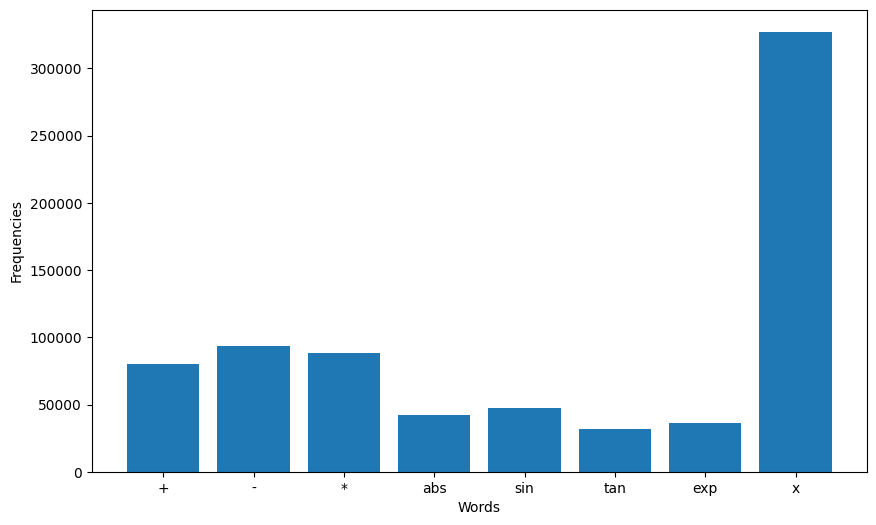

In [26]:
## TODO: Plot a histogram showing the count of each token (symbol) over the entire training dataset.
# Create a dictionary with each token and its count value
all_tokens = list(binary_operators.keys()) + list(unary_operators.keys()) + list(leaves) + [None,]
token_count = {token[1] : 0 for token in enumerate(all_tokens)}

for seq in seqs_filtered:
    for s in seq:
      token_count[s] += 1

plt.figure(figsize=(10, 6))
words = list(token_count.keys())

# Remove None keyword as we cannot plot it
words.pop()
freq = list(token_count.values())
freq.pop()

plt.bar(words, freq)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.show()

# Part 3: Training a deep neural network to carry out symbolic regression

We are now ready to train a neural network to carry out symbolic regression.

We will train the network to **iteratively** generate expressions. More specifically, during **training**, we will teach the network to perform **next token prediction** — given a partial tree sequence of tokens and $\mathscr{D}$, it learns to predict the next token in the sequence.

Then, during **inference**, we generate the full output using **autoregression** — given an empty starting sequence and $\mathscr{D}$, we predict the next token, append it to the sequence, and repeat this process until an end-of-sequence token is predicted or a maximum sequence length is reached.


<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-train.png" width="80%"></div>

<div align="center"><img src="https://benmoseley.blog/uploads/teaching/2025-AIMS-SA/symbolic-regression-infer.png" width="80%"></div>


We will use the special end of sequence (`<EOS>`) token to allow the network to predict the end of a sequence, and the pad (`<PAD>`) token to randomly pad the front of each training example so that the network can learn to predict tokens at different parts of the tree.

The network will be trained using a **cross-entropy loss** on next-token prediction. Mathematically, given a training sequence of tokens $(x_1, x_2, \dots, x_T)$, the loss is defined as:

$$
\mathscr{L} = - \log(p(x_T | x_1, x_2, \dots, x_{T-1}, \mathscr{D}))
$$

where $p(x_T | x_1, x_2, \dots, x_{T-1}, \mathscr{D})$ is the probability assigned by the model to the correct next token $x_T$, given the previous token sequence of length `T - 1` and the input data observations $\mathscr{D}$.

The network predicts the class probability of the next token. Note we remove the `<PAD>` token from the final output classes, such that there are `n_tokens - 1` output classes.

Overall, our approach trains the model to build expressions one token at a time while implicitly learning the structure and syntax of mathematical expressions.

## Part 3a: Defining a neural network for symbolic regression

For simplicity, we will use a simple fully connected encoder-decoder architecture for our neural network.

During training, the inputs and outputs of the model must have the following shapes:

Inputs:
- Batch of $\mathscr{D}$: shape `(B, N, 2)`
- Batch of previous token sequence: shape `(B, T - 1)`

Outputs:
- Batch of class probabilities for next token: shape (`B, n_tokens - 1`) (Note we remove the `<PAD>` token from the final output classes).

Here `N` is the number of data observations, `T` is the maximum tree size, `B` is the batch size, and `n_tokens` is the number of tokens in the vocabulary.

> **Task 3.1**: Our PyTorch model is defined below. Finish writing the `inference` function, which autoregressively predicts an expression sequence given `data`. Check that the `forward` and `inference` functions behave as you expect.

> HINT: you can use `torch.argmax(logits, dim=1)` to get the most likely token predicted by the model.

In [33]:
print(np.shape(datas_filtered)) # Batches, no. of points, dimension

(65462, 100, 2)


In [39]:
batch_size = 64
tensor_data = torch.tensor(datas_filtered, dtype=torch.float32)

In [54]:
# Split the data 80/20 into train and test - round 80% to closest int
slice_idx = round(0.8*(tensor_data.shape[0]))
train_data = tensor_data[:slice_idx]
test_data = tensor_data[slice_idx:]

train_dataset = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")
print(f"Number of batches: {train_dataset.__len__()}")
data_0 = next(iter(train_dataset))
print(f"Data size: {data_0.shape}")

Number of training examples: 819
Number of test examples: 205
Number of batches: 819
Data size: torch.Size([64, 100, 2])


In [55]:
class SeqFCN(nn.Module):
    def __init__(self, N, T, n_tokens, d_model=128, n_enc_layers=2, n_decode_layers=2):
        super().__init__()
        self.N = N
        self.T = T
        self.n_tokens = n_tokens

        # nn.Embedding used to store word embeddings and retrieve them using indices.
        # num_embeddings – size of the dictionary of embeddings = n_tokens
        # embedding_dim – the size of each embedding vector - 4?
        self.embed = nn.Embedding(n_tokens, 4)

        enc_layers = [nn.Linear(N*2, d_model), nn.GELU()]

        # Add more encoding layers based on the input parameter
        for _ in range(n_enc_layers):
          enc_layers += [nn.Linear(d_model, d_model), nn.GELU()]

        # Sequentially execute the embedding layers
        self.embedding = nn.Sequential(*enc_layers)

        # Decoding structure
        # The decoder takes an input with dimensions of

In [ ]:
class SeqFCN(nn.Module):
    def __init__(self, N, T, n_tokens, d_model=128, n_enc_layers=2, n_dec_layers=2):
        """
        Initialize the SeqFCN model.

        Args:
            N (int): Number of input data points.
            T (int): Maximum length of the token sequence.
            n_tokens (int): Size of the vocabulary.
            d_model (int, optional): Dimension of the model's hidden state (default is 128).
            n_enc_layers (int, optional): Number of layers in the encoder (default is 2).
            n_dec_layers (int, optional): Number of layers in the decoder (default is 2).
        """
        super().__init__()
        self.N = N
        self.T = T
        self.n_tokens = n_tokens

        # Embedding for symbolic input
        self.embed1 = nn.Embedding(n_tokens, 4)

        # Encoder: input is flattened data values of shape (B, N*2)
        enc_layers = [nn.Linear(N*2, d_model), nn.ReLU()]
        for _ in range(n_enc_layers - 1):
            enc_layers += [nn.Linear(d_model, d_model), nn.ReLU()]
        self.encoder = nn.Sequential(*enc_layers)

        # Decoder: input is encoder_out + embedded tree vector
        input_dim = d_model + 4 * (T - 1)
        dec_layers = [nn.Linear(input_dim, d_model), nn.ReLU()]
        for _ in range(n_dec_layers - 1):
            dec_layers += [nn.Linear(d_model, d_model), nn.ReLU()]
        dec_layers += [nn.Linear(d_model, n_tokens - 1)]  # Don't predict padding token
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, data, x):
        """
        Next token class prediction.

        Args:
            data: Tensor of shape (B, N, 2) — data observations
            x: Tensor of shape (B, T - 1) — previous token sequence

        Returns:
            logits: Tensor of shape (B, n_tokens - 1) - class probabilities of next token (raw logits)
        """
        # encode data
        B = x.shape[0]
        d = data.view(B, -1)         # Flatten input: (B, 2 * N)
        d = self.encoder(d)          # (B, d_model)

        # embed tokens
        x = self.embed1(x)           # (B, T-1, 4)
        x = x.view(B, -1)            # (B, 4 * (T - 1))

        # decode class probabilities (raw logits)
        x = torch.cat([d, x], dim=1) # (B, d_model + 4 * (T - 1))
        logits = self.decoder(x)     # (B, n_tokens - 1)
        return logits

    def inference(self, data):
        """
        Predict entire expression sequence autoregressively from `data`.

        Args:
            data: Tensor of shape (B, N, 2) — data observations

        Returns:
            x: Tensor of shape (B, T) - sequence of tokens
        """
        B = data.shape[0]
        x = torch.ones((B, self.T), dtype=torch.long) * forward_token_map["<PAD>"]  # Initialize `x` with all pad tokens
        for _ in range(self.T):  # Loop over entire sequence


            ## TODO: autoregressively predict entire sequence


            ##



        return x

# Example initialization and check
N = 100
T = (2*(max_n_binary_operators + max_n_unary_operators) + 1) + 1  # max tree size in training dataset = max number of nodes + max number of leaves + EOS token
print(f"Maximum tree size (T): {T}")
print(f"Vocabulary size (n_tokens): {n_tokens}")

torch.manual_seed(123)
model = SeqFCN(N, T, n_tokens)
print(model)
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters()):.2e}")

# Test forward pass and inference
data = torch.ones(200, N, 2)
x = torch.ones(200, T - 1, dtype=torch.long)
assert model(data, x).shape == (200, n_tokens - 1)
assert model.inference(data).shape == (200, T)


## Part 3b: Training the network

Finally, we will train the model using our training dataset and a cross entropy loss function.

Note when sampling batches of training examples, we apply random left-padding to each expression sequence, with up to `T - 1` `<PAD>` tokens, followed by right-padding with `<EOS>` tokens until each expression has the same maximum length of `T`.

> **Task 3.2**: Use the code below to train the `SeqFCN` model. Improve the `test` function so that it also reports the accuracy of the model (number of expressions correctly guessed).


In [ ]:
# Define train/test datasets
# Stack filtered data (B, N, 2)
datas_ = np.stack(datas_filtered, axis=0)  # Shape: (B, N, 2)

# Stack vector representations, padding with <EOS> token to max length T
vecs_ = np.stack([np.concatenate([vec, forward_token_map["<EOS>"] * np.ones(T - vec.shape[0], dtype=int)])  # Pad with <EOS>
                 for vec in vecs_filtered], axis=0)  # Shape: (B, T)

# Print shapes to verify correctness
print(datas_.shape, vecs_.shape)

# Split into train (80%) and test (20%)
split = 8 * datas_.shape[0] // 10
train_dataset = torch.utils.data.TensorDataset(torch.tensor(datas_[:split], dtype=torch.float32),
                                               torch.tensor(vecs_[:split], dtype=torch.long))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(datas_[split:], dtype=torch.float32),
                                              torch.tensor(vecs_[split:], dtype=torch.long))

# Print dataset sizes
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

In [ ]:
def train(model, train_dataset, test_dataset, batch_size=100, n_steps=50000, lr=1e-3):
    """
    Trains the model on the given training dataset and evaluates it on both training and test datasets periodically.

    Args:
        model: The model to train.
        train_dataset: The dataset used for training.
        test_dataset: The dataset used for testing.
        batch_size: The number of samples per batch during training (default 100).
        n_steps: The number of training steps (default 50000).
        lr: The learning rate for the optimizer (default 1e-3).

    Returns:
        The trained model.
    """
    # Set random seed for reproducibility
    torch.manual_seed(123)

    # Create DataLoader for training dataset
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Initial evaluation on train and test datasets
    test(model, train_dataset, "train")
    test(model, test_dataset, "test")

    # Set the device for model (GPU if available, else CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Set model to training mode
    model.train()

    i = 0
    while i < n_steps:
        for batch_idx, (data_batch, vecs_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            data_batch = data_batch.to(device)  # (B, N, 2)
            vecs_batch = vecs_batch.to(device)  # (B, T)

            # Randomly add padding to the front of vecs_batch, cropping back to max sequence length T
            x = torch.arange(vecs_batch.shape[0]).unsqueeze(1).expand(vecs_batch.shape)
            y = torch.arange(vecs_batch.shape[1]).unsqueeze(0).expand(vecs_batch.shape)
            shifts = torch.randint(1, vecs_batch.shape[1], (vecs_batch.shape[0],))  # 1 to T-1 pad tokens at front
            y = y + shifts.view(-1, 1)
            padded = torch.cat([torch.full_like(vecs_batch, forward_token_map["<PAD>"]), vecs_batch], axis=1)
            vecs_batch = padded[x, y]  # (B, T)

            # Compute loss and optimize model
            logits = model(data_batch, vecs_batch[:, :-1])  # (B, n_tokens-1)
            loss = criterion(logits, vecs_batch[:, -1])
            loss.backward()
            optimizer.step()

            # Track and display progress
            i += 1
            if i % 1000 == 0 or i == 1:
                print(f"{i}/{n_steps}, {loss.item()}")
            if i % 5000 == 0:
                test(model, train_dataset, "train")
                test(model, test_dataset, "test")
                model.to(device)
                model.train()

            if i >= n_steps:
                break

    return model

def test(model, dataset, tag):
    """
    Evaluates the model on the given dataset and prints the accuracy.
    Also plots some predictions vs. true expressions.

    Args:
        model: The model to evaluate.
        dataset: The dataset to evaluate on.
        tag: A string to label the dataset (e.g., "train", "test").
    """
    model.to(torch.device("cpu"))
    model.eval()

    preds, targets = [], []
    with torch.no_grad():
        # Collect predictions and targets from the dataset
        for data_batch, vecs_batch in torch.utils.data.DataLoader(dataset, batch_size=500, shuffle=False):
            pred = model.inference(data_batch)
            preds.append(pred)
            targets.append(vecs_batch)

    # Concatenate predictions and targets
    preds = torch.concat(preds)  # (B, T)
    targets = torch.concat(targets)  # (B, T)


    ## TODO: report the accuracy of the model (number of expressions correctly predicted)


    ##


    # Plot some expression predictions
    nrows, ncols = 6, 6
    plt.figure(figsize=(0.7 * np.array([ncols * 2.5, nrows * 2.5])))

    for i in range(min(nrows * ncols, len(dataset))):
        # Get symbol sequences from predicted vectors
        seq_pred = [backward_token_map[t.item()] for t in preds[i]]
        assert "<PAD>" not in seq_pred
        seq_true = [backward_token_map[t.item()] for t in targets[i]]
        assert "<PAD>" not in seq_true

        # Cut sequence after first <EOS> token
        try:
            ix = seq_pred.index("<EOS>")
            seq_pred = seq_pred[:ix]
        except: pass
        try:
            ix = seq_true.index("<EOS>")
            seq_true = seq_true[:ix]
        except: pass

        # Convert symbol sequence to tree and expression
        try:
            root_pred = prefix_sequence_to_tree(seq_pred, binary_operators, unary_operators, leaves)
            expr_pred = tree_to_sympy(root_pred, binary_operators, unary_operators, leaves)
        except:  # If not a valid expression
            expr_pred = None

        # True expression
        root_true = prefix_sequence_to_tree(seq_true, binary_operators, unary_operators, leaves)
        expr_true = tree_to_sympy(root_true, binary_operators, unary_operators, leaves)

        # Plot the true and predicted expressions
        def plot_expr(expr, label):
            x = np.linspace(-1, 1, 100)
            f = sp.lambdify(args=sp.symbols(leaves), expr=expr, modules="numpy")(x)
            if isinstance(f, (int, float)): f *= np.ones(100)
            plt.plot(x, f, label=f"{label} {expr}")

        plt.subplot(nrows, ncols, i + 1)
        plot_expr(expr_true, "true")

        if expr_pred is None:
            plt.plot([0], [0], label="pred invalid expr")
        else:
            plot_expr(expr_pred, "pred")

        plt.legend(fontsize="xx-small")

    plt.show()

# Initialize the model
torch.manual_seed(123)
model = SeqFCN(N, T, n_tokens)
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters()):.2e}")

# Train the model
model = train(model, train_dataset, test_dataset)

## Part 3c: Open-ended exploration and written report

> **Task 3.3**: This is an open-ended task. Think of ways that the model and or training algorithm could be improved, and/or ways to better analyse the predictions of the model, and try these out. For example, you could investigate:
- Comparisons of the performance of different hyperparameters, and other neural network architectures (e.g. Transformers)
- Analysis of the generalisation / out-of-distribution performance of the network
- Written thoughts on limitations and future extensions of your model
>
> Use the space below to write a **summary report** on your findings.
>
> The report can include text, figures, code snippets, and any other colab cell outputs you think are appropriate.